# Taming Transformers
## Reconstruction Capabilities of VQGAN (Colab Notebook)

This notebook provides code to (visually) analyze the first stage models used to generate images as in [Taming Transformers for High-Resolution Image Synthesis](https://github.com/CompVis/taming-transformers)
and a comparison to the first stage model used in [DALL-E](https://openai.com/blog/dall-e/).

### Setup
Clone the repository and download pretrained VQGANs: a small one with a codebook dimensionality $\dim \mathcal{Z} = 1024$
and a larger one with $ \dim \mathcal{Z} = 16384$. Both perform *four* downsampling steps, e.g. an input image of
size $256 \times 256$ will be mapped to a latent code of size $16 \times 16$.

In [128]:
# !git clone https://github.com/CompVis/taming-transformers  
# %cd taming-transformers


# download a VQGAN with a codebook with 1024 entries
!mkdir -p /ssd1/shpark/taming-transformers/logs/vqgan_imagenet_f16_1024/checkpoints
!mkdir -p /ssd1/shpark/taming-transformers/logs/vqgan_imagenet_f16_1024/configs
!wget 'https://heibox.uni-heidelberg.de/f/140747ba53464f49b476/?dl=1' -O '/ssd1/shpark/taming-transformers/logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt' 
!wget 'https://heibox.uni-heidelberg.de/f/6ecf2af6c658432c8298/?dl=1' -O '/ssd1/shpark/taming-transformers/logs/vqgan_imagenet_f16_1024/configs/model.yaml' 

# # download a VQGAN with a larger codebook (16384 entries)
# !mkdir -p logs/vqgan_imagenet_f16_16384/checkpoints
# !mkdir -p logs/vqgan_imagenet_f16_16384/configs
# !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt' 
# !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'logs/vqgan_imagenet_f16_16384/configs/model.yaml' 

--2021-06-09 16:36:40--  https://heibox.uni-heidelberg.de/f/140747ba53464f49b476/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/78d1038e-f7aa-4a64-89d0-923fd5ad3a6f/last.ckpt [following]
--2021-06-09 16:36:41--  https://heibox.uni-heidelberg.de/seafhttp/files/78d1038e-f7aa-4a64-89d0-923fd5ad3a6f/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 957954257 (914M) [application/octet-stream]
Saving to: ‘/ssd1/shpark/taming-transformers/logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt’

/ssd1/shpark/taming 100%[===================>] 913.58M  10.7MB/s    in 94s     

2021-06-09 16:38:15 (9.75 MB/s) - ‘/ssd1/shpark/taming-transformers/logs/vqgan_imagenet_f16_1024/checkpoints/

Install minimal required dependencies.

In [37]:
%%capture
# %pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8
import sys
sys.path.append("..")

# also disable grad to save memory
import torch
torch.set_grad_enabled(False)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Define some loading utilities

In [38]:
import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel

def load_config(config_path, display=False):
  config = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config)))
  return config

def load_vqgan(config, ckpt_path=None):
  model = VQModel(**config.model.params)
  if ckpt_path is not None:
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
  return model.eval()

def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def reconstruct_with_vqgan(x, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  z, _, [_, _, indices] = model.encode(x)
  print(f"VQGAN: latent shape: {z.shape[2:]}")
  xrec = model.decode(z)
  return xrec

## Load the VQGANs

First, load (and optionally display) the model configs. Then, load the VQGAN models.

In [213]:
# config1024 = load_config("../logs/2021-06-09T01-42-19_custom_vqgan/configs/2021-06-09T01-42-19-project.yaml", display=False)
# config16384 = load_config("logs/vqgan_imagenet_f16_16384/configs/model.yaml", display=False)
config1024 = load_config("../logs/2021-06-10T21-42-59_fashiongen_vqgan/configs/2021-06-10T21-42-59-project.yaml", display=False)



# model1024 = load_vqgan(config1024, ckpt_path="../logs/2021-06-09T01-42-19_custom_vqgan/checkpoints/last.ckpt").to(DEVICE)
model1024 = load_vqgan(config1024, ckpt_path="../logs/2021-06-10T21-42-59_fashiongen_vqgan/checkpoints/last.ckpt").to(DEVICE)
# model16384 = load_vqgan(config16384, ckpt_path="logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(DEVICE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


## DALL-E joins the party
Code reproduced from the official notebook available at https://github.com/openai/DALL-E/blob/master/notebooks/usage.ipynb

In [ ]:
%pip install git+https://github.com/openai/DALL-E.git &> /dev/null

In [196]:
import io
import os, sys
import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from dall_e          import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf", 22)

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))

def load_image(path):
    return PIL.Image.open(path)

def preprocess(img, target_image_size=256):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)


def reconstruct_with_dalle(x, encoder, decoder, do_preprocess=False):
  # takes in tensor (or optionally, a PIL image) and returns a PIL image
  if do_preprocess:
    x = preprocess(x)
  z_logits = encoder(x)
  z = torch.argmax(z_logits, axis=1)
  
  print(f"DALL-E: latent shape: {z.shape}")
  z = F.one_hot(z, num_classes=encoder.vocab_size).permute(0, 3, 1, 2).float()

  x_stats = decoder(z).float()
  x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
  x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

  return x_rec


def stack_reconstructions(input, x1, titles=[]):
  assert input.size == x1.size 
  w, h = input.size[0], input.size[1]
  img = Image.new("RGB", (2*w, h))
  img.paste(input, (0,0))
  img.paste(x1, (1*w,0))
#   img.paste(x2, (2*w,0))
#   img.paste(x3, (3*w,0))
  for i, title in enumerate(titles):
    ImageDraw.Draw(img).text((i*w, 0), f'{title}', (255, 255, 255), font=font) # coordinates, text, color, font
  return img

Load the provided encoder and decoder.

In [ ]:
# For faster load times, download these files locally and use the local paths instead.
encoder_dalle = load_model("https://cdn.openai.com/dall-e/encoder.pkl", DEVICE)
decoder_dalle = load_model("https://cdn.openai.com/dall-e/decoder.pkl", DEVICE)

## Reconstruct some images

Define the reconstruction pipeline and stack the reconstructions for a direct comparison.

In [214]:
titles=["Input", "VQGAN"]

def reconstruction_pipeline(path, size=256):
  x = preprocess(load_image(path), target_image_size=size)
  x = x.to(DEVICE)
  print(f"input is of size: {x.shape}")
#   x1 = reconstruct_with_vqgan(preprocess_vqgan(x), model16384)
  x2 = reconstruct_with_vqgan(preprocess_vqgan(x), model1024)
#   x3 = reconstruct_with_dalle(x, encoder_dalle, decoder_dalle)
  img = stack_reconstructions(custom_to_pil(preprocess_vqgan(x[0])), custom_to_pil(x2[0]), titles=titles)
  return img

In [215]:
SAMPLE_BASE_PATH = '/ssd1/shpark/taming-transformers/fashiongen-output/train/class/'

# INDEX = 9981

# PATH = SAMPLE_BASE_PATH + str(INDEX) + '.jpg'

In [217]:
sample_list = os.listdir(SAMPLE_BASE_PATH)[:30]

imgs = []

for item in sample_list:
    path = SAMPLE_BASE_PATH + item
    imgs.append(reconstruction_pipeline(path, size=256))

input is of size: torch.Size([1, 3, 256, 256])
VQGAN: latent shape: torch.Size([16, 16])
input is of size: torch.Size([1, 3, 256, 256])
VQGAN: latent shape: torch.Size([16, 16])
input is of size: torch.Size([1, 3, 256, 256])
VQGAN: latent shape: torch.Size([16, 16])
input is of size: torch.Size([1, 3, 256, 256])
VQGAN: latent shape: torch.Size([16, 16])
input is of size: torch.Size([1, 3, 256, 256])
VQGAN: latent shape: torch.Size([16, 16])
input is of size: torch.Size([1, 3, 256, 256])
VQGAN: latent shape: torch.Size([16, 16])
input is of size: torch.Size([1, 3, 256, 256])
VQGAN: latent shape: torch.Size([16, 16])
input is of size: torch.Size([1, 3, 256, 256])
VQGAN: latent shape: torch.Size([16, 16])
input is of size: torch.Size([1, 3, 256, 256])
VQGAN: latent shape: torch.Size([16, 16])
input is of size: torch.Size([1, 3, 256, 256])
VQGAN: latent shape: torch.Size([16, 16])
input is of size: torch.Size([1, 3, 256, 256])
VQGAN: latent shape: torch.Size([16, 16])
input is of size: tor

In [218]:
sample_list

['145073.jpg',
 '26591.jpg',
 '83012.jpg',
 '213627.jpg',
 '96658.jpg',
 '39977.jpg',
 '157988.jpg',
 '40878.jpg',
 '153644.jpg',
 '204888.jpg',
 '39525.jpg',
 '36593.jpg',
 '42387.jpg',
 '17868.jpg',
 '146369.jpg',
 '102080.jpg',
 '85613.jpg',
 '17516.jpg',
 '250518.jpg',
 '19536.jpg',
 '153292.jpg',
 '83253.jpg',
 '217072.jpg',
 '18054.jpg',
 '10267.jpg',
 '215700.jpg',
 '239323.jpg',
 '171886.jpg',
 '94443.jpg',
 '206302.jpg']

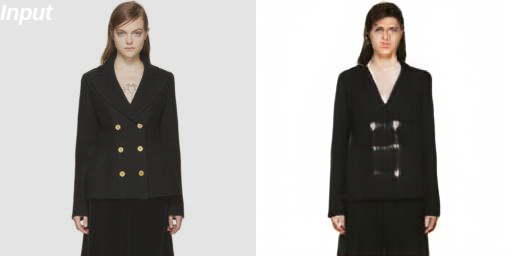

In [221]:
imgs[15]

Let's reconstruct some images from the [DIV2K](https://data.vision.ee.ethz.ch/cvl/DIV2K/) dataset.

input is of size: torch.Size([1, 3, 384, 384])
VQGAN: latent shape: torch.Size([24, 24])


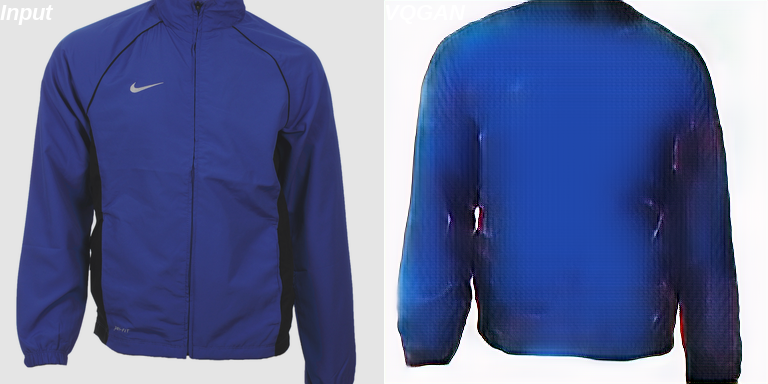

In [77]:
reconstruction_pipeline(PATH, size=384)

Especially at regions like the squirrel's fur and tail, the VQGANs produce plausible textures whereas the first stage of DALL-E produces overly smooth regions despite using four times more codes. On the other hand, using fewer codes means that the VQGAN cannot reproduce every detail of its input but instead hallucinates parts of it. In particular, the VQGAN (1024) has difficulties reconstructing the foot, which can be remedied to some degree by the bigger codebook size of VQGAN (16384).

In [121]:
reconstruction_pipeline(url='https://heibox.uni-heidelberg.de/f/6f12b330eb564d288d76/?dl=1', size=384)

TypeError: reconstruction_pipeline() got an unexpected keyword argument 'url'

input is of size: torch.Size([1, 3, 384, 384])
VQGAN: latent shape: torch.Size([24, 24])


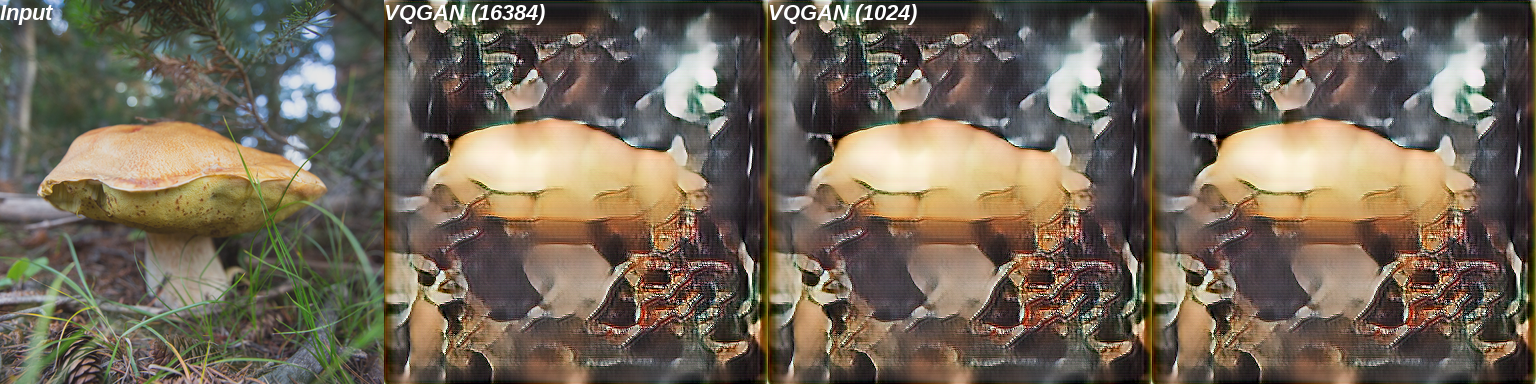

In [44]:
reconstruction_pipeline(url='https://heibox.uni-heidelberg.de/f/8555a959b0a5423cbfd1/?dl=1', size=384)

input is of size: torch.Size([1, 3, 384, 384])
VQGAN: latent shape: torch.Size([24, 24])


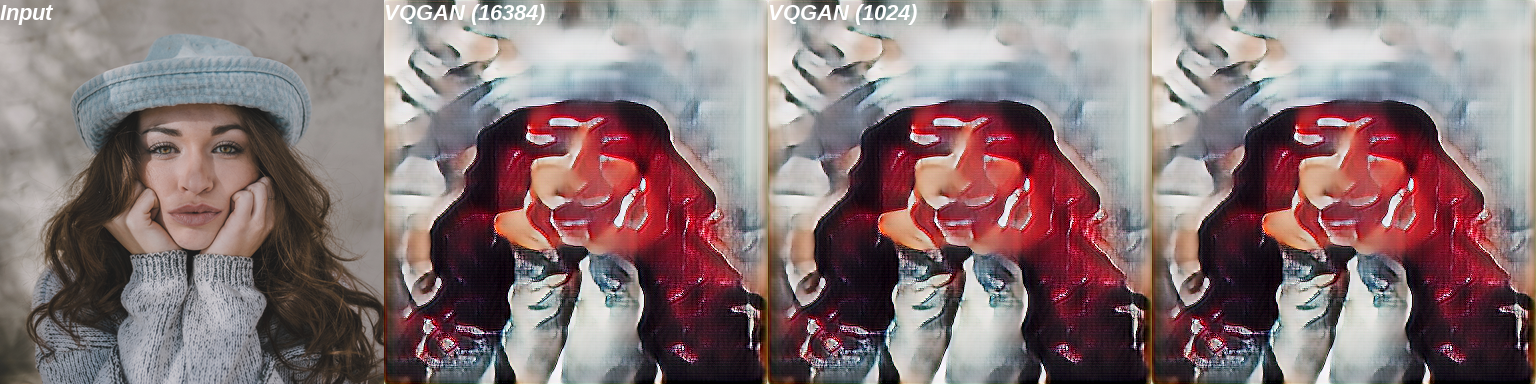

In [45]:
reconstruction_pipeline(url='https://heibox.uni-heidelberg.de/f/be6f4ff34e1544109563/?dl=1', size=384)

Faces are particularly difficult for the VQGAN to get right and the reconstructions of DALL-E's first stage appear more presentable. However, it should also be noted that the latter has been trained on a dataset which is roughly 400 times larger than the dataset (ImageNet) that the VQGAN was trained on. Thus, training the VQGAN on a larger dataset, or fine-tuning it on a dataset containing more faces, could improve the perceptual quality of reconstructed faces (and VQGANs trained on face datasets only do not show this problem).

input is of size: torch.Size([1, 3, 384, 384])
VQGAN: latent shape: torch.Size([24, 24])


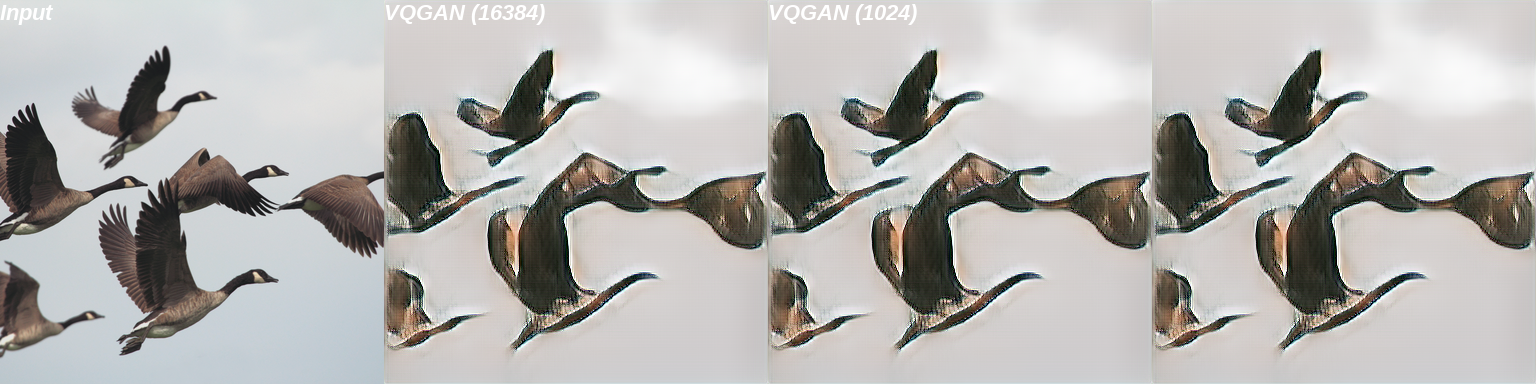

In [24]:
reconstruction_pipeline("https://heibox.uni-heidelberg.de/f/e41f5053cbd34f11a8d5/?dl=1", size=384)

And finally, the penguin.

input is of size: torch.Size([1, 3, 384, 384])
VQGAN: latent shape: torch.Size([24, 24])


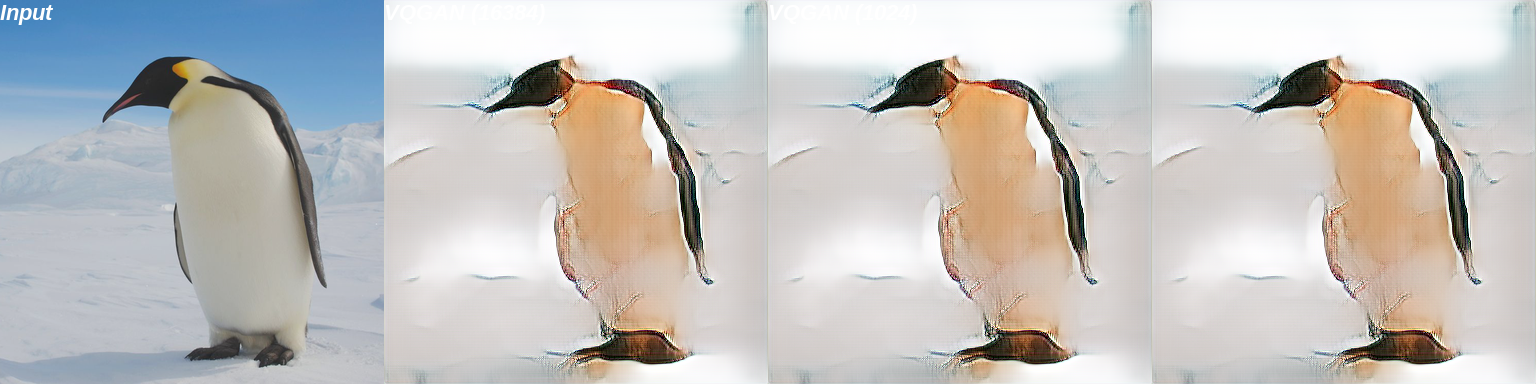

In [25]:
reconstruction_pipeline(url='https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iKIWgaiJUtss/v2/1000x-1.jpg', size=384)

## Conclusion

These examples show that the use of an adversarial loss applied in a patch-wise manner does indeed help to produce reconstructions that favor *realism* over a perfect reconstruction (but may cause "deletion" of certain objects, such as the pine cone in the 4th example). Furthermore, the adversarial training enables very agressive downsampling: Given an image of size $256 \times 256$, the VQGAN produces a sequence of length $16 \cdot 16 = 256$ (vs. $32 \cdot 32 = 1024$ for DALL-E). This supports downstream tasks such as training attention-based models on the latent space, which, in their basic form, scale quadratically with sequence length. Thus, training the same transformer on top of the codes produced by the VQGAN is roughly 16 times faster than training it on top of DALL-E's first stage.

We also observe that a more realistic and faithful reconstruction can be achieved if $\vert \mathcal{Z} \vert$ is increased. Note, however, that a lower codebook dimensionality can also help a downstream autoregressive likelihood model (such as our transformer) to generate more global structures.


One way to quantify the amount of "realism" captured by these models is to compute FID scores of reconstructed images w.r.t. the inputs (R-FIDs). The following table shows R-FIDs when reconstructing the validation split of the ImageNet dataset ($256 \times 256$ px images). Additionally, we also evaluate the perceptual similarity between inputs and reconstructions with the [LPIPS](https://richzhang.github.io/PerceptualSimilarity/) metric and structural similarity through PSNR and SSIM.


|   | VQGAN (16384) |  VQGAN (1024)  |  DALL-E |
|---| :---:| :---: | :---: |
| R-FID 	$\downarrow$ | 4.9 | 8.0 | 34.3 |
| LPIPS 	$\downarrow$ | 1.83 +/- 0.42 | 1.98 +/- 0.43 | 1.95 +/- 0.51 |
| PSNR 	$\uparrow$ | 19.9 +/- 3.4 | 19.4 +/- 3.3 | 22.8 +/- 2.1 |
| SSIM 	$\uparrow$ | 0.51 +/- 0.18 | 0.50 +/- 0.18 | 0.73 +/- 0.13 |



Finally, note that these models can be used in a fully convolutional fashion: For an input of size $(h, w)$, the corresponding latent representation is always $(h/2^m, w/2^m)$, with $m=4$ for the VQGANs presented here and $m=3$ for the autoencoder of DALL-E. 

input is of size: torch.Size([1, 3, 256, 256])
VQGAN: latent shape: torch.Size([16, 16])
VQGAN: latent shape: torch.Size([16, 16])
DALL-E: latent shape: torch.Size([1, 32, 32])


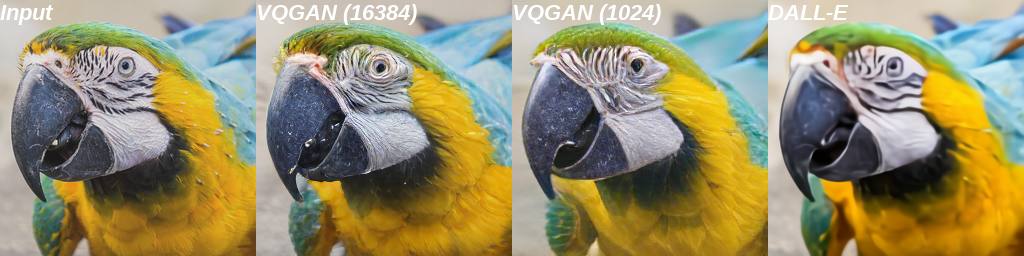

input is of size: torch.Size([1, 3, 512, 512])
VQGAN: latent shape: torch.Size([32, 32])
VQGAN: latent shape: torch.Size([32, 32])
DALL-E: latent shape: torch.Size([1, 64, 64])


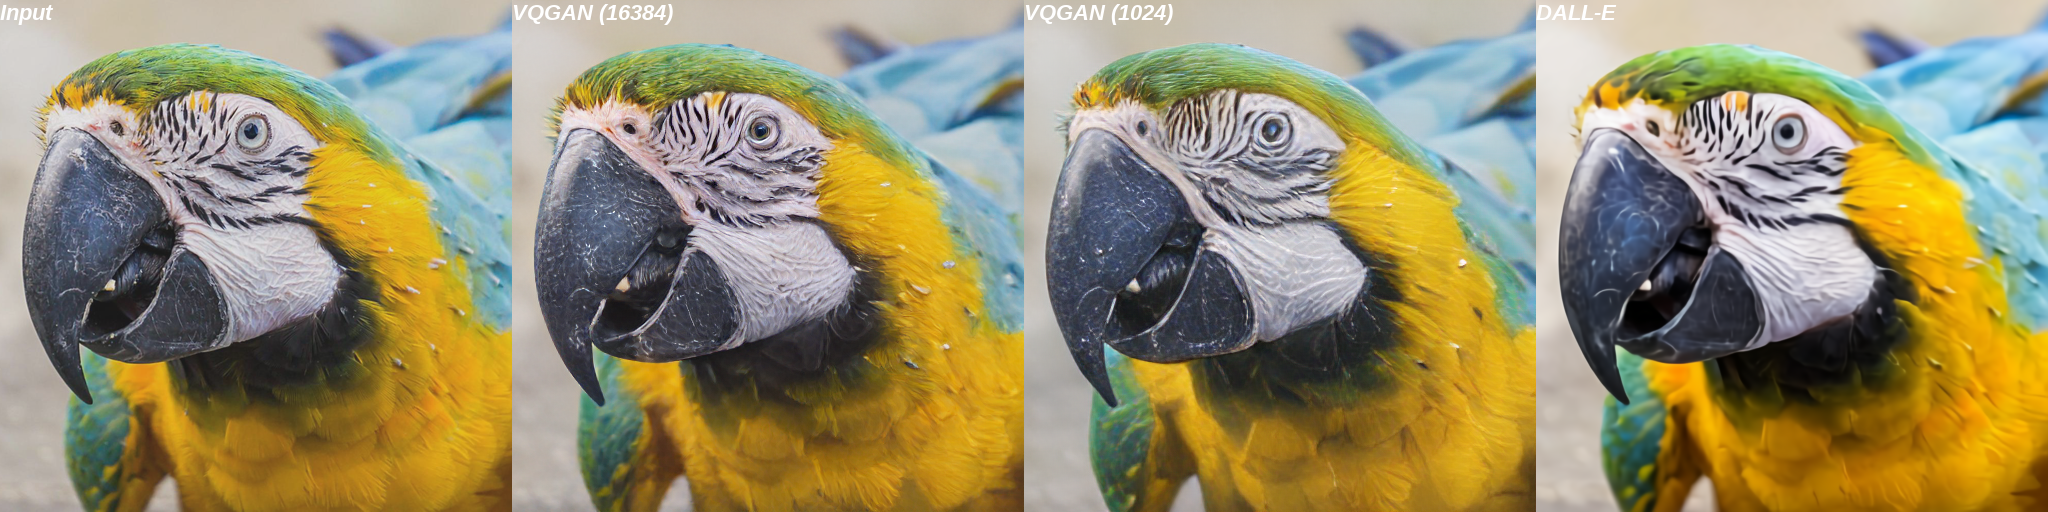

In [ ]:
display(reconstruction_pipeline("https://heibox.uni-heidelberg.de/f/5cfd15de5d104d6fbce4/?dl=1", size=256))
display(reconstruction_pipeline("https://heibox.uni-heidelberg.de/f/5cfd15de5d104d6fbce4/?dl=1", size=512))